In [1]:
import numpy as np
from scipy.special import logsumexp
import time
import pickle
import matplotlib.pyplot as plt

In [2]:
class BaseOracle(object):
    """
    Base class for implementation of oracles.
    """ 
    def dual_func(self, u, v):
        """
        Computes the value of function at point (u, v).
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def dual_func_grad(self, u, v):
        """
        Computes the gradient at point (u, v).
        """
        raise NotImplementedError('Grad oracle is not implemented.')
        
    def duality_gap(self, u, v):
        """
        Computes the value of duality gap at point (u, v).
        """
        raise NotImplementedError('Func oracle is not implemented.')
        

class UnbalancedOTOracle(BaseOracle):
    """
    Oracle for Unbalanced OT 
    """

    def __init__(self, gamma, rho, source, target, cost_matrix):
        self.gamma = gamma
        self.rho = rho
        self.source = np.copy(source)
        self.target = np.copy(target)
        self.cost = np.copy(cost_matrix)

    def dual_func(self, u, v):
        A = - (self.cost + u[:, np.newaxis] + v[np.newaxis, :]) / self.gamma
        dual_func = self.gamma * np.exp(logsumexp(A)) + self.rho * np.dot(np.exp(u / self.rho) - 1, self.source) + \
                                                        self.rho * np.dot(np.exp(v / self.rho) - 1, self.target)
        return dual_func

    def dual_func_grad(self, u, v):
        A = - (self.cost + u[:, np.newaxis] + v[np.newaxis, :]) / self.gamma
        grad_u = np.exp(u / self.rho) * self.source - np.exp(logsumexp(A, axis = 1))
        grad_v = np.exp(v / self.rho) * self.target - np.exp(logsumexp(A, axis = 0))
        return (grad_u, grad_v)
    
    def duality_gap(self, u, v):
        A = - (self.cost + u[:, np.newaxis] + v[np.newaxis, :]) / self.gamma
        res = np.exp(u / self.rho).dot(self.source) + np.exp(v / self.rho).dot(self.target) + \
              (- u / self.rho + logsumexp(A, axis = 1) - np.log(self.source) - 1).dot(np.exp(logsumexp(A, axis = 1))) + \
              (- v / self.rho + logsumexp(A, axis = 0) - np.log(self.target) - 1).dot(np.exp(logsumexp(A, axis = 0)))
        return self.rho * res
    

In [3]:
def sinkhorn_unb(oracle, u_0 = None, v_0 = None, max_iter = 100000, 
                 verbose = True, history = True, iters = None):
    K = - oracle.cost / oracle.gamma
    coeff = oracle.rho * oracle.gamma / (oracle.rho + oracle.gamma)
    log_p = np.log(oracle.source)
    log_q = np.log(oracle.target)
    u = - oracle.gamma * log_p if u_0 is None else np.copy(u_0)
    v = - oracle.gamma * log_q if v_0 is None else np.copy(v_0)
    if history:
        if iters is None:
            iters = list(range(max_iter + 1))
        hist_len = len(iters)
        dual_gap_hist = np.empty(hist_len)
        dual_func_hist = np.empty(hist_len)
        if iters[0] == 0:
            dual_gap_hist[0] = oracle.duality_gap(u, v)
            dual_func_hist[0] = oracle.dual_func(u, v)
            iter_count = 1
        else:
            iter_count = 0
    bar_size = 50
    bar_pos = 0
    
    for count in range(1, max_iter + 1):
        u = coeff * (logsumexp(K - v[np.newaxis, :] / oracle.gamma, axis = 1) - log_p)
        v = coeff * (logsumexp(K - u[:, np.newaxis] / oracle.gamma, axis = 0) - log_q)
        if history and count == iters[iter_count]:
            dual_gap_hist[iter_count] = oracle.duality_gap(u, v)
            dual_func_hist[iter_count] = oracle.dual_func(u, v)
            iter_count = min(iter_count + 1, hist_len - 1) 
        if verbose and round(bar_size * count / max_iter) > bar_pos:
            bar_pos = round(bar_size * count / max_iter)
            print('\r[{}] {}%'.format('=' * bar_pos + ' ' * (bar_size - bar_pos), round(100 * count / max_iter)),
                  end = '', flush = True)
        
    if verbose:
        print('\r' + ' ' * (bar_size + 7), end = '\r')
        print('Iterations number exceeded!')
    if history:
        return u, v, dual_gap_hist, dual_func_hist
    else:
        return u, v

In [23]:
from math import sqrt
def astm(oracle, t_start = None, L_init = None, max_iter = 1000, verbose = False, history = True, iters = None):
    iter_step = 100
    L_value = 1.0 if L_init is None else L_init  #np.linalg.norm(phi_big_oracle.grad(t_start))
    
    t_start = - oracle.gamma * np.concatenate((np.log(oracle.source), np.log(oracle.target))) if t_start is None else np.copy(t_start)
    source_len = len(oracle.source)
    
    A_prev = 0.0
    y_start = zeta_prev = t_prev = np.copy(t_start)
    A = zeta = t = y = None
    
    if history:
        if iters is None:
            iters = list(range(max_iter + 1))
        hist_len = len(iters)
        dual_gap_hist = np.empty(hist_len)
        dual_func_hist = np.empty(hist_len)
        inner_iters_hist = []
        if iters[0] == 0:
            dual_gap_hist[0] = oracle.duality_gap(t_start[ : source_len], t_start[source_len :])
            dual_func_hist[0] = oracle.dual_func(t_start[ : source_len], t_start[source_len :])
            iter_count = 1
        else:
            iter_count = 0
    bar_size = 50
    bar_pos = 0

    for count in range(1,max_iter+1): #y -> lambda, t -> eta, u -> zeta
        inner_iters_num = 1
        while True:
            alpha = 0.5 / L_value + sqrt(0.25 / L_value**2 + A_prev / L_value)
            #alpha = 0.5 / L_value * (1 + sqrt(1 + 4 * A_prev * L_value))
            A = A_prev + alpha

            y = (alpha * zeta_prev + A_prev * t_prev) / A
            phi_grad_y = np.concatenate(oracle.dual_func_grad(y[ : source_len], y[source_len :]))
            zeta = zeta_prev - alpha * phi_grad_y #prox_h
            t = (alpha * zeta + A_prev * t_prev) / A

            left_value = oracle.dual_func(y[ : source_len], y[source_len :]) + np.dot(phi_grad_y, t - y) - \
                         oracle.dual_func(t[ : source_len], t[source_len :])
            right_value = - 0.5 * L_value * np.sum((t - y)**2)
            if left_value >= right_value:
                break
            else:
                L_value *= 2
                inner_iters_num += 1

        A_prev = A
        L_value /= 2
        t_prev = t
        zeta_prev = zeta
        
        if history and count == iters[iter_count]:
            dual_gap_hist[iter_count] = oracle.duality_gap(t[ : source_len], t[source_len :])
            dual_func_hist[iter_count] = oracle.dual_func(t[ : source_len], t[source_len :])
            inner_iters_hist.append(inner_iters_num)
            iter_count = min(iter_count + 1, hist_len - 1) 
        if verbose and round(bar_size * count / max_iter) > bar_pos:
            bar_pos = round(bar_size * count / max_iter)
            print('\r[{}] {}%'.format('=' * bar_pos + ' ' * (bar_size - bar_pos), round(100 * count / max_iter)),
                  end = '', flush = True)
    if verbose:
        print('\nIterations number exceeded!')
        print('Inner iterations total number: ' + str(sum(inner_iters_history)))
    
    return t[ : source_len], t[source_len :], dual_gap_hist, dual_func_hist, inner_iters_hist

## Experiments

In [30]:
from sklearn.metrics.pairwise import pairwise_distances
n = 100
m = 200
p = np.zeros(n) + 1e-10
p[0:200] = 1
p = p / np.sum(p)
q = np.zeros(m) + 1e-10
q[300:700] = 1
q = q / np.sum(q)

coord_x = np.linspace(0,1,n)[:,np.newaxis]
coord_y = np.linspace(0,1,m)[:,np.newaxis]
C = pairwise_distances(coord_x, coord_y, 'sqeuclidean')

### Sinkhorn

In [31]:
max_iter = 10000
iters = list(range(100)) + list(range(100, 1000, 10)) + \
        list(range(1000, 10000, 100)) + list(range(10000, max_iter + 1, 1000))
iters = [it for it in iters if it <= max_iter]
dual_gap = []
dual_func = []

gammas = np.logspace(0, -5, 6)
rho = 1
for gamma in gammas:
    print('gamma =', gamma)
    start = time.time()
    oracle = UnbalancedOTOracle(gamma, rho, p, q, C)
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        _, _, dg, df = sinkhorn_unb(oracle, max_iter = max_iter, iters = iters)
    stop = time.time()
    print('Elapsed time: {0:.1f} sec.'.format(stop - start))
    dual_gap.append(dg)
    dual_func.append(df)

gamma = 1.0
Iterations number exceeded!                              
Elapsed time: 16.0 sec.
gamma = 0.1
Iterations number exceeded!                              
Elapsed time: 15.0 sec.
gamma = 0.01
Iterations number exceeded!                              
Elapsed time: 11.4 sec.
gamma = 0.001
Iterations number exceeded!                              
Elapsed time: 22.6 sec.
gamma = 0.0001
Iterations number exceeded!                              
Elapsed time: 159.4 sec.
gamma = 1e-05
Iterations number exceeded!                              
Elapsed time: 141.3 sec.


In [32]:
data = {'C': C, 'p': p, 'q': q, 'rho' : rho, 'gammas': gammas, 'iters': iters, 
        'df_hist': dual_func, 'dg_hist': dual_gap}
#with open('exp1_unb_sinkhorn.pickle', 'wb') as f:
#    pickle.dump(data, f)

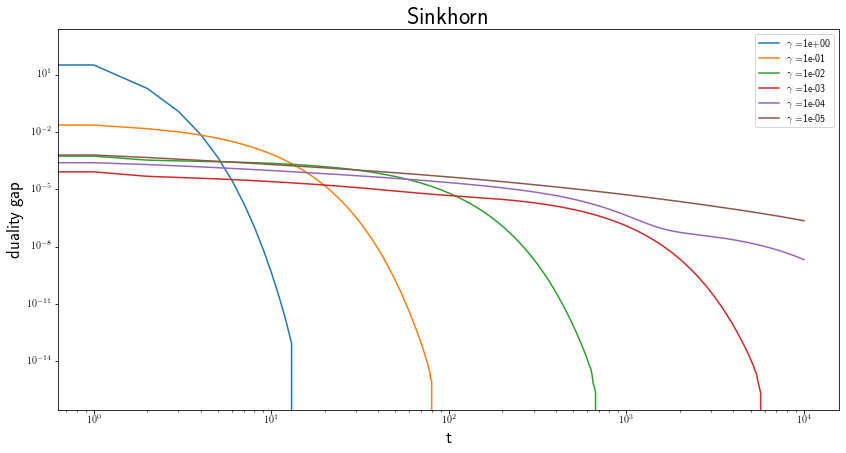

In [34]:
plt.rc('text', usetex=True)
plt.figure(figsize = (14, 7))
for k, gamma in enumerate(gammas):
    dg = dual_gap[k]
    x = np.array(iters[:len(dg)])
    plt.plot(x, dg, label = r'$\gamma=${0:.0e}'.format(gamma))
axes = plt.gca()
#axes.set_xlim([1, np.max(x) * 2])
plt.xlabel('t', fontsize = 18)
plt.xscale('log')
plt.ylabel('duality gap', fontsize = 18)
plt.yscale('log')
plt.legend()
plt.title('Sinkhorn', fontsize = 24)
#plt.savefig('sinkhorm_unb_ot.png')
plt.show()

### ASTM

In [27]:
max_iter = 10000
iters = list(range(100)) + list(range(100, 1000, 10)) + \
        list(range(1000, 10000, 100)) + list(range(10000, max_iter + 1, 1000))
iters = [it for it in iters if it <= max_iter]
dual_gap = []
dual_func = []
iters_hists = []

gammas = np.logspace(0, -5, 6)
rho = 1
for gamma in gammas:
    print('gamma =', gamma)
    start = time.time()
    oracle = UnbalancedOTOracle(gamma, rho, p, q, C)
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        _, _, dg, df, iters_hist = astm(oracle, max_iter = max_iter, iters = iters)
    stop = time.time()
    print('Elapsed time: {0:.1f} sec.'.format(stop - start))
    dual_gap.append(dg)
    dual_func.append(df)
    iters_hists.append(iters_hist)

gamma = 1.0
Elapsed time: 74.1 sec.
gamma = 0.1
Elapsed time: 72.5 sec.
gamma = 0.01
Elapsed time: 83.2 sec.
gamma = 0.001
Elapsed time: 120.7 sec.
gamma = 0.0001
Elapsed time: 550.9 sec.
gamma = 1e-05
Elapsed time: 804.6 sec.


In [28]:
data = {'C': C, 'p': p, 'q': q, 'rho' : rho, 'gammas': gammas, 'iters': iters, 
        'df_hist': dual_func, 'dg_hist': dual_gap}
#with open('exp1_unb_astm.pickle', 'wb') as f:
#    pickle.dump(data, f)

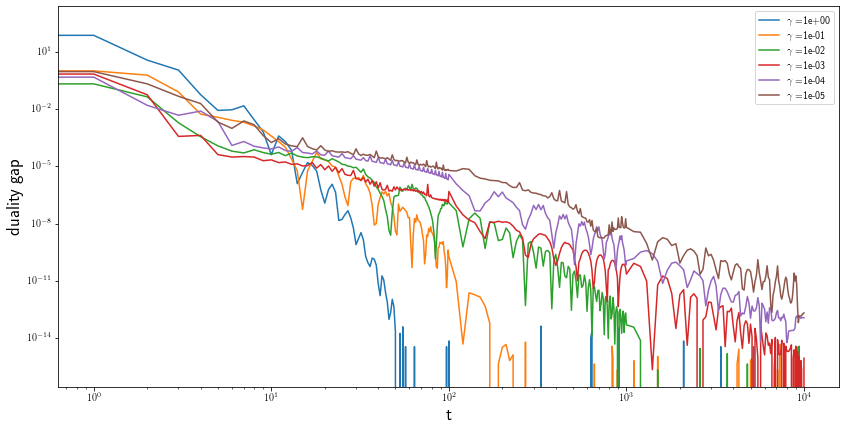

In [29]:
plt.rc('text', usetex=True)
plt.figure(figsize = (14, 7))
for k, gamma in enumerate(gammas):
    dg = dual_gap[k]
    x = np.array(iters[:len(dg)])
    plt.plot(x, dg, label = r'$\gamma=${0:.0e}'.format(gamma))
axes = plt.gca()
#axes.set_xlim([1, np.max(x) * 2])
plt.xlabel('t', fontsize = 18)
plt.xscale('log')
plt.ylabel('duality gap', fontsize = 18)
plt.yscale('log')
plt.legend()
#plt.savefig('astm_unb_ot.png')
plt.show()